In [1]:
options(repr.plot.width  = 15, repr.plot.height = 10)

# Libraries

In [2]:
#install.packages("gbm")
#install.packages("xgboost")
#install.packages("doParallel")

In [3]:
library(tidyverse)

# Modeling packages
library(caret)
library(gbm)      # Implementacion de al forma clasica de gradient boosting en R
library(xgboost)  # General implementacion para extreme gradient boosting
library(gridExtra)
library(recipes)

library(doParallel)
library(vip)



── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loaded gbm 2.1.8


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘recipes’


The following object is masked from ‘package:stringr’:

    fixed


The following object is masked from ‘package:stats’:

    step


Loading required package: foreach


Attaching package:

# Load data

In [4]:
path_data = '/home/creyesp/Projects/repos/r-course/data/online_shoppers_intention.csv'

column_parser <- cols(
    Administrative = col_character(),
    Administrative_Duration = col_double(),
    Informational = col_character(),
    Informational_Duration = col_double(),
    ProductRelated = col_character(),
    ProductRelated_Duration = col_double(),
    BounceRates = col_double(),
    ExitRates = col_double(),
    PageValues = col_double(),
    SpecialDay = col_double(),
    Month = col_character(),
    OperatingSystems = col_character(),
    Browser = col_character(),
    Region = col_character(),
    TrafficType = col_character(),
    VisitorType = col_character(),
    Weekend = col_character(),
    Revenue = col_logical()
)

data = readr::read_delim(path_data, delim=',', col_types = column_parser)

In [5]:
categorical = c(
    'Month',
    'VisitorType',
    'OperatingSystems',
    'Browser',
    'Region',
    'TrafficType',
    'Administrative',
    'Informational',
    'ProductRelated',
    'Weekend'
)
numerical = c(
    'Administrative_Duration',
    'Informational_Duration',
    'ProductRelated_Duration',
    'BounceRates',
    'ExitRates',
    'PageValues',
    'SpecialDay'
)
outcome = 'Revenue'

# Split Dataset

In [6]:
set.seed(42)

index_train <- createDataPartition(data$Revenue, p = 0.8, list = FALSE)
retention_train <- data[index_train, ]
retention_test  <- data[-index_train, ]

head(retention_train)

Warning message:
“The `i` argument of ``[`()` can't be a matrix as of tibble 3.0.0.
Convert to a vector.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
0,0,0,0,1,0.000000,0.20,0.20,0,0.0,Feb,1,1,1,1,Returning_Visitor,FALSE,FALSE
0,0,0,0,2,64.000000,0.00,0.10,0,0.0,Feb,2,2,1,2,Returning_Visitor,FALSE,FALSE
0,-1,0,-1,1,-1.000000,0.20,0.20,0,0.0,Feb,4,1,9,3,Returning_Visitor,FALSE,FALSE
0,0,0,0,2,2.666667,0.05,0.14,0,0.0,Feb,3,2,2,4,Returning_Visitor,FALSE,FALSE
0,0,0,0,10,627.500000,0.02,0.05,0,0.0,Feb,3,3,1,4,Returning_Visitor,TRUE,FALSE
0,-1,0,-1,1,-1.000000,0.20,0.20,0,0.4,Feb,2,4,3,3,Returning_Visitor,FALSE,FALSE


# Overview

In [7]:
head(retention_train[categorical])

Month,VisitorType,OperatingSystems,Browser,Region,TrafficType,Administrative,Informational,ProductRelated,Weekend
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Feb,Returning_Visitor,1,1,1,1,0,0,1,FALSE
Feb,Returning_Visitor,2,2,1,2,0,0,2,FALSE
Feb,Returning_Visitor,4,1,9,3,0,0,1,FALSE
Feb,Returning_Visitor,3,2,2,4,0,0,2,FALSE
Feb,Returning_Visitor,3,3,1,4,0,0,10,TRUE
Feb,Returning_Visitor,2,4,3,3,0,0,1,FALSE


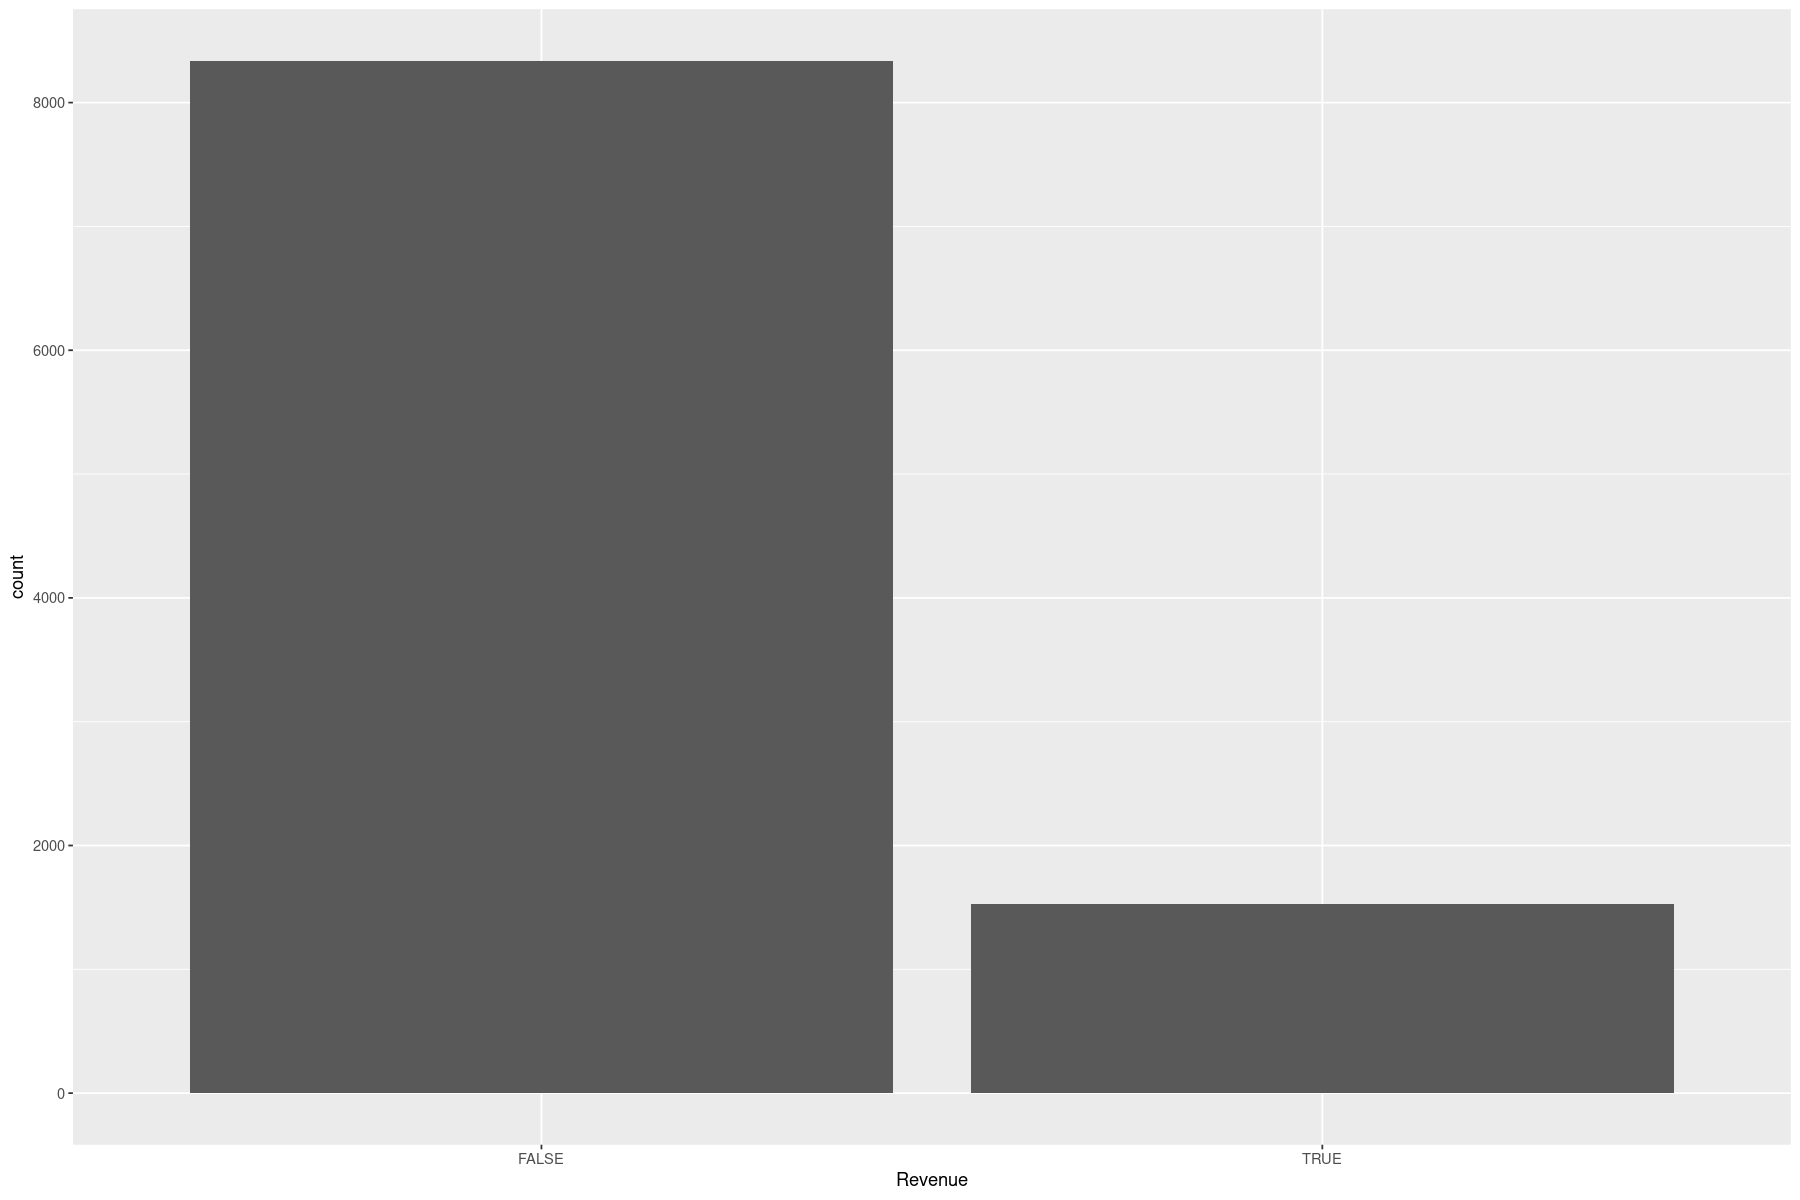

In [8]:
retention_train %>% 
    ggplot(aes(Revenue)) + 
        geom_bar()

In [9]:
as.integer(retention_train$Revenue)

[1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [38] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  [75] 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [112] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [149] 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 [186] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 [223] 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 [260] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 [297] 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 [334] 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [371] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 [408] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [445] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 [482] 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 [519] 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 [556] 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [593] 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 [630] 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 [667] 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 [704] 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [741] 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [778] 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [815] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 [852] 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [889] 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [926] 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0
 [963] 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0
[1000] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1037] 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1
[1074] 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
[1111] 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1148] 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1185] 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
[1222] 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
[1259] 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0
[1296] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0
[1333] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1370] 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0
[1407] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0
[1444] 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
[1481] 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0
[1518] 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
[1555] 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
[1592] 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1
[1629] 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
[1666] 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1
[1703] 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
[1740] 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1
[1777] 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0
[1814] 0 0 0 0 0 0 1 1 0 0 0 0 0 0

# Loss function
La *loss function* es una medida que indica que tan bien los parametros del modelo ajustan a los datos de entrenamiento y en general minimizan el error. Para los problemas de clasificación se suele usar la **Binary Cross entropy / Log Loss** dado que es diferenciable y eso facilita el proceso de optimizacion de los algortimos.  
Como vimos en la clase de arboles se suele usar la entropia o el indice de gini como criterio para hacer buscar el mejor split en un node (feautute, threshold). Adicionalmente en el caso de las tecnicas de boosting se usar la misma funcion para busca en cada iteracion el mejor arbol para reducir el error.

<img src="https://miro.medium.com/max/548/1*rdBw0E-My8Gu3f_BOB6GMA.png">

In [10]:
cost_func <- function(obs, pred){
    -(obs*log(pred, base = 2) + (1 - obs)*log(1 - pred, base = 2))
}
cost_func(1, 0.5)
cost_func(1, 0.2)
cost_func(1, 0.8)
cost_func(0, 0.5)
cost_func(0, 0.2)
cost_func(0, 0.8)

[1] 1

[1] 2.321928

[1] 0.3219281

[1] 1

[1] 0.3219281

[1] 2.321928

# GBM

**Hyperparameters**
La version clasica de GBM tiene 2 tipos de hiper-parametros:
   * boosting
   * especificos de los arboles

**Hiper-parametros de Boosting**
* **Numero de arboles**: el numero total de arboles en la secuencia. A diferencia de Bagging y RF donde el numero de arboles raramente puede generar overfitting, en boosting el hecho de la dependencia con el error del arbol anterior lo hace propenso a hacer overfittig, en general este numero puede variar en dependencia de los otros hiper-pármetros.
* **Learning rate (shrinkage)**: determina la contribucion de cada arbon en el resultado final  y controla la velocidad con la que el algoritmo desciende. Este valor va entre $[0, 1]$ y valores tipicos van entre $0.001$ - $0.3$. Valores mas pequeños hacen mas robusto a caracteristicas especificas de cada arbol, permitiendo generalizaar bien. Sin embargo valores pequeños pueden llevar a no encontrar el punto optimo y quedar en un minimo local. Generalmente valores mas pequeños logran un performance mejor pero requiere de un numero mayor de arboles en la secuencia.

**Hiper-parametros propios de cada arbol**

* **Profundidad del arbol**: Controla el la profundida maxima de cada arbol. Los valores tipicos van entre 3-8 pero no es raro ver arboles con profundad 1. Valore bajos son computacionalmente eficiente pero requiren de mas arboles en toral. Sin embargo valores mas grandes permiten capturar interacciones entre las features pero lo hace propenso a hacer overfitting.
* **Numero minimo de observacioens en un nodo**: controla la complejidad del arbon. Dado que los arboles tienden a ser poco profundos tiende a tener poco efecto. Valore tipicos van entre 5-15. Valores grandes pueden ayudar a prevenir relaciones muy especificas entre variables (overfitting) pero para los casos de dataset desbalanceados valores pequeños pueden ayudar a detectar los casos de la clase minoritaria.

## Feature engineering

In [11]:
prep_retention <- recipe(Revenue ~ ., data = retention_train) %>%
    step_medianimpute(all_of(numerical)) %>% 
    step_string2factor(all_of(categorical)) %>% 
    step_knnimpute(all_of(categorical)) %>% 
    step_mutate(Revenue = as.integer(Revenue)) %>% 
    prep()
    
retention_train_clean  <-  bake(prep_retention, retention_train)
retention_test_clean  <-  bake(prep_retention, retention_test)

In [12]:
head(retention_train_clean)

Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>
0,0,0,0,1,0.000000,0.20,0.20,0,0.0,Feb,1,1,1,1,Returning_Visitor,FALSE,0
0,0,0,0,2,64.000000,0.00,0.10,0,0.0,Feb,2,2,1,2,Returning_Visitor,FALSE,0
0,-1,0,-1,1,-1.000000,0.20,0.20,0,0.0,Feb,4,1,9,3,Returning_Visitor,FALSE,0
0,0,0,0,2,2.666667,0.05,0.14,0,0.0,Feb,3,2,2,4,Returning_Visitor,FALSE,0
0,0,0,0,10,627.500000,0.02,0.05,0,0.0,Feb,3,3,1,4,Returning_Visitor,TRUE,0
0,-1,0,-1,1,-1.000000,0.20,0.20,0,0.4,Feb,2,4,3,3,Returning_Visitor,FALSE,0


## Modeling
En R hay un paquete llamada GBM que implementa *Gradient Bossting Machine* y tiene alguno de los siguientes hiperparametros
* **distribution** = nombre de la loss function. Para clasificacion binaria "Logistic loss"/"Bernoulli loss"
* **n.trees** = numero de iteraciones/arboles para entrenar (default=100)
* **shrinkage** = learning rate (default=0.1)
* **interaction.depth** = maxima profuncidad del arbol (default=1)
* **n.minobsinnode** = minimo de observaciones en un arbol (default=10)
* **bag.fraction** = fraccion del total de observaciones que se usan para entrenar un nuevo arbon en cada iteracion (default=0.5)
* **train.fraction** = fracción del total de observaciones que se usa para entrenar el modelo en cada iteracion, el resto se usar para evaluar con un conjunto no visto en entrenamiento (default=1)
* **class.stratify.cv** = Si el problema es de clasificacion de hace un sample estratificado para mantener la proporcion del target (default=NULL)
* **cv.folds** = numero de CV que se realizan (default=0)

### GBM model 1

In [71]:
set.seed(42)

retention_gbm1 <- gbm(
  formula = Revenue ~ .,
  data = retention_train_clean,
  distribution = "bernoulli",
  n.trees = 100,
  shrinkage = 0.1,
  interaction.depth = 1,
  n.minobsinnode = 10,
  bag.fraction = 0.5,
  class.stratify.cv = TRUE,
  cv.folds = 5
)

# Encuentra el numero de arboles que genera el menor error
best <- which.min(retention_gbm1$cv.error)

retention_gbm1$cv.error[best]

[1] 0.5577608

### Optimum iteration
GBM implementa una funcion para encontrar el valor optimo de iteraciones donde se minimiza el error `gbm.perf`, adicionalmente te genera una grafica del error en cada iteración

[1] 28

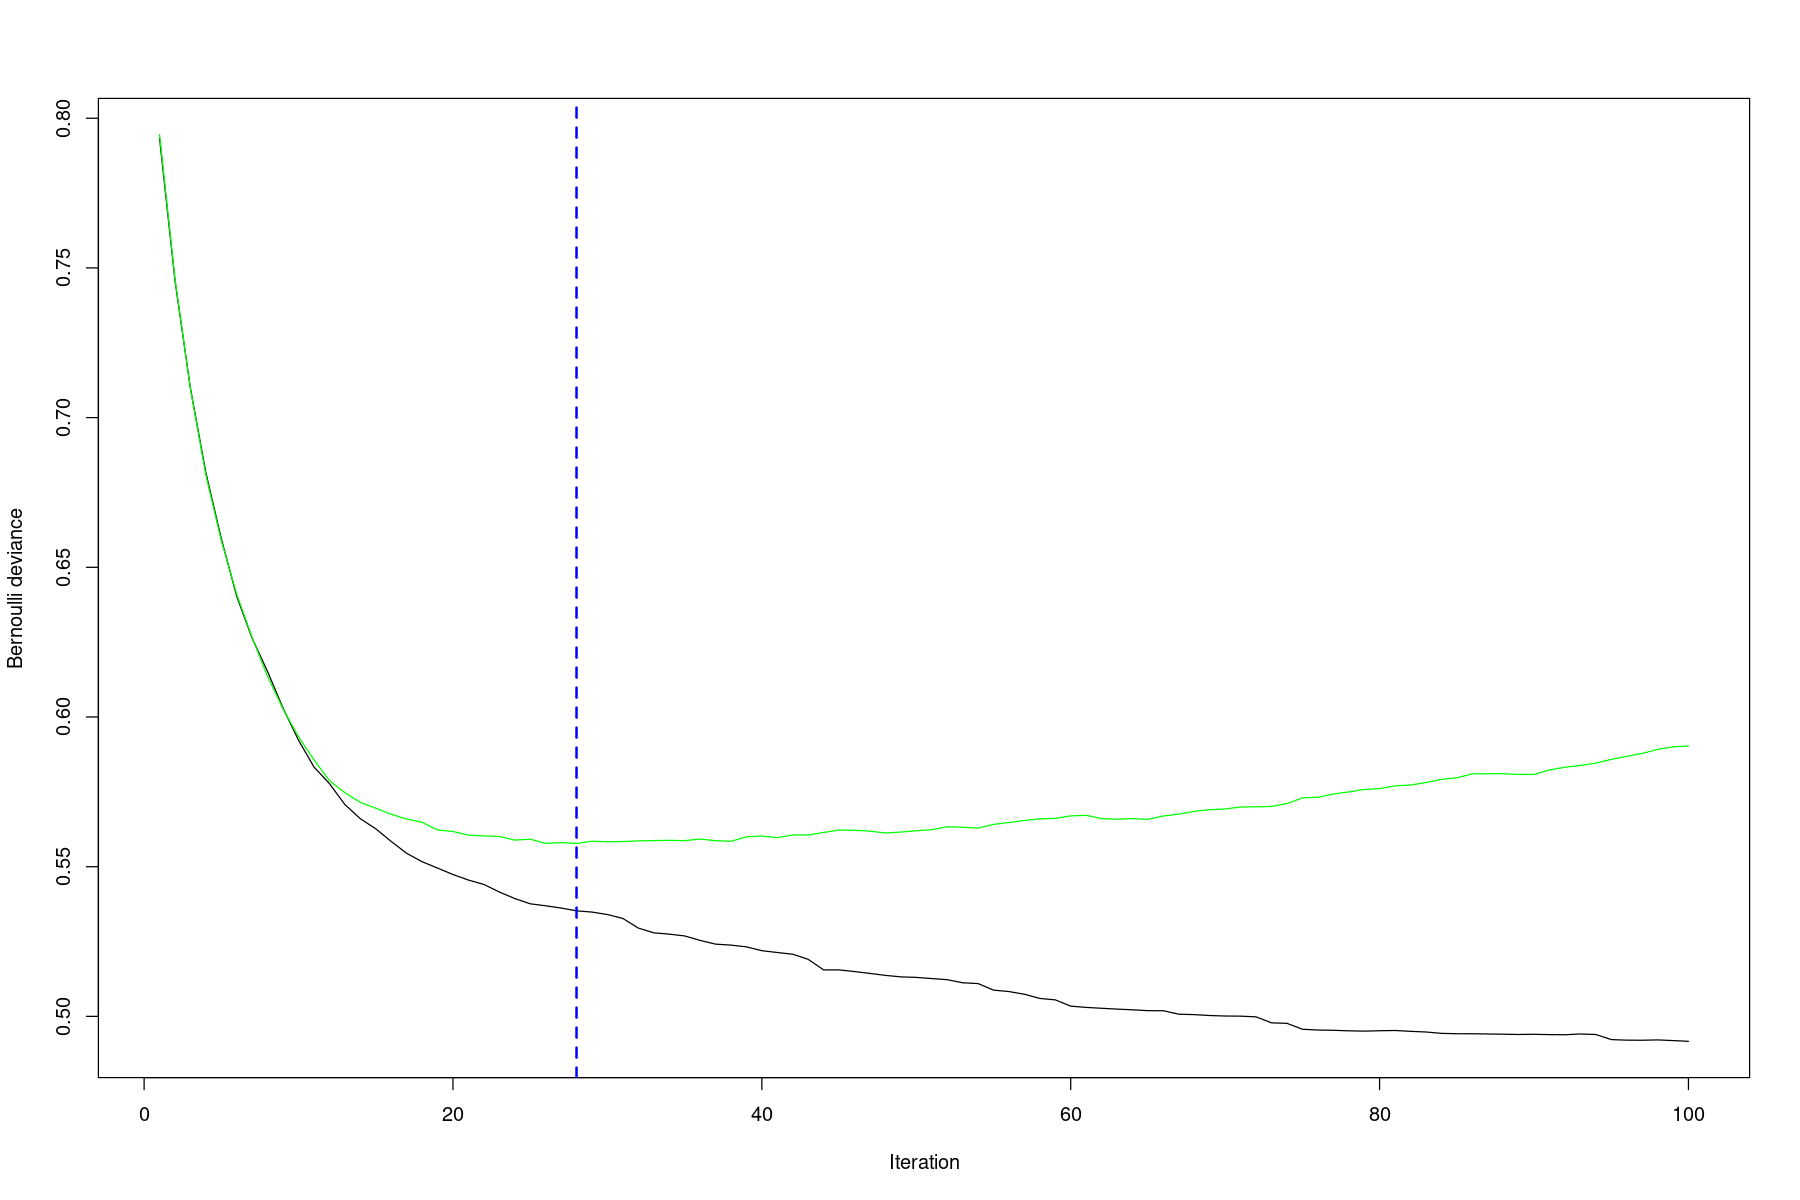

In [70]:
best_fit <- gbm.perf(retention_gbm1, method = "cv")
best_fit

### Predictions
Las predicciones en GB devuelven solo la probabilidad

In [61]:
pred_retention_test <- predict(retention_gbm1, newdata = retention_test_clean, type='response')
head(pred_retention_test)

Using 33 trees...




[1] 0.04114820 0.03460252 0.03586314 0.03460252 0.03460252 0.03460252

### Evaluation
#### Train

In [79]:
data_to_eval = retention_train_clean
pred_retention <- predict(retention_gbm1, newdata = data_to_eval, type='response')

confusionMatrix(data = as.factor(ifelse(pred_retention>0.5, 1, 0)),
                reference = as.factor(data_to_eval$Revenue),
                positive='1',
                mode='prec_recall'
               )

Using 28 trees...




Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 7965  664
         1  373  863
                                          
               Accuracy : 0.8949          
                 95% CI : (0.8887, 0.9009)
    No Information Rate : 0.8452          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5644          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
              Precision : 0.69822         
                 Recall : 0.56516         
                     F1 : 0.62468         
             Prevalence : 0.15479         
         Detection Rate : 0.08748         
   Detection Prevalence : 0.12529         
      Balanced Accuracy : 0.76021         
                                          
       'Positive' Class : 1               
                                          

#### Test

In [80]:
data_to_eval = retention_test_clean
pred_retention <- predict(retention_gbm1, newdata = data_to_eval, type='response')

confusionMatrix(data = as.factor(ifelse(pred_retention>0.5, 1, 0)),
                reference = as.factor(data_to_eval$Revenue),
                positive='1',
                mode='prec_recall'
               )

Using 28 trees...




Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1977  159
         1  107  222
                                          
               Accuracy : 0.8921          
                 95% CI : (0.8792, 0.9041)
    No Information Rate : 0.8454          
    P-Value [Acc > NIR] : 1.222e-11       
                                          
                  Kappa : 0.5627          
                                          
 Mcnemar's Test P-Value : 0.001766        
                                          
              Precision : 0.67477         
                 Recall : 0.58268         
                     F1 : 0.62535         
             Prevalence : 0.15456         
         Detection Rate : 0.09006         
   Detection Prevalence : 0.13347         
      Balanced Accuracy : 0.76567         
                                          
       'Positive' Class : 1               
                                          

# General tuning strategy
A diferencia de Random Forest, GBM tiene una alta variabilidad en las metricas de performance dependiendo de los valores que definamos para el modelo. De esta forma tenemos que tener mayor entendiemiento del efecto de cada hiper-parametro y definir una estrategia mas elavorada que en RF. En general un buen plan es:

* Elegir un learning rate (*lr*) alto. Por lo general el valor por defecto es 0.1 pero puede variar entre 0.05-0.3 dependiendo del problema.
* Determina el numero optimo de iteraciones/arboles para ese *lr*. 
* Modifica los hiper-parametros de los arboles y ajusta el *lr* para la opcion que te de mejor resultado. 
* Explora disminuir el *lr* en busqueda de pequeñas mejoras
* Si en los pasos anteriores no utilizaste CV reentrena con los mejores hiperparametros y usa CV para obtener resultados mas robustos.

## Modeling
### GBM model 2

In [19]:
set.seed(42)

retention_gbm2 <- gbm(
  formula = Revenue ~ .,
  data = retention_train_clean,
  distribution = "bernoulli",
  n.trees = 100,
  shrinkage = 0.1,
  interaction.depth = 2,
  n.minobsinnode = 10,
  class.stratify.cv = TRUE,
  cv.folds = 5
)

# Encuentra el numero de arboles que genera el menor error
best <- which.min(retention_gbm2$cv.error)

retention_gbm2$cv.error[best]

[1] 0.5514763

In [21]:
set.seed(42)

retention_gbm3 <- gbm(
  formula = Revenue ~ .,
  data = retention_train_clean,
  distribution = "bernoulli",
  n.trees = 100,
  shrinkage = 0.1,
  interaction.depth = 4,
  n.minobsinnode = 10,
  class.stratify.cv = TRUE,
  cv.folds = 5
)

# Encuentra el numero de arboles que genera el menor error
best <- which.min(retention_gbm3$cv.error)

retention_gbm3$cv.error[best]

[1] 0.547505

In [22]:
set.seed(42)

retention_gbm4 <- gbm(
  formula = Revenue ~ .,
  data = retention_train_clean,
  distribution = "bernoulli",
  n.trees = 100,
  shrinkage = 0.1,
  interaction.depth = 7,
  n.minobsinnode = 10,
  class.stratify.cv = TRUE,
  cv.folds = 5
)

# Encuentra el numero de arboles que genera el menor error
best <- which.min(retention_gbm4$cv.error)

retention_gbm4$cv.error[best]

[1] 0.549264

In [24]:
set.seed(42)

retention_gbm5 <- gbm(
  formula = Revenue ~ .,
  data = retention_train_clean,
  distribution = "bernoulli",
  n.trees = 1000,
  shrinkage = 0.005,
  interaction.depth = 4,
  n.minobsinnode = 10,
  class.stratify.cv = TRUE,
  cv.folds = 5
)

# Encuentra el numero de arboles que genera el menor error
best <- which.min(retention_gbm5$cv.error)

retention_gbm5$cv.error[best]

[1] 0.5416111

### Optimum iteration

[1] 582

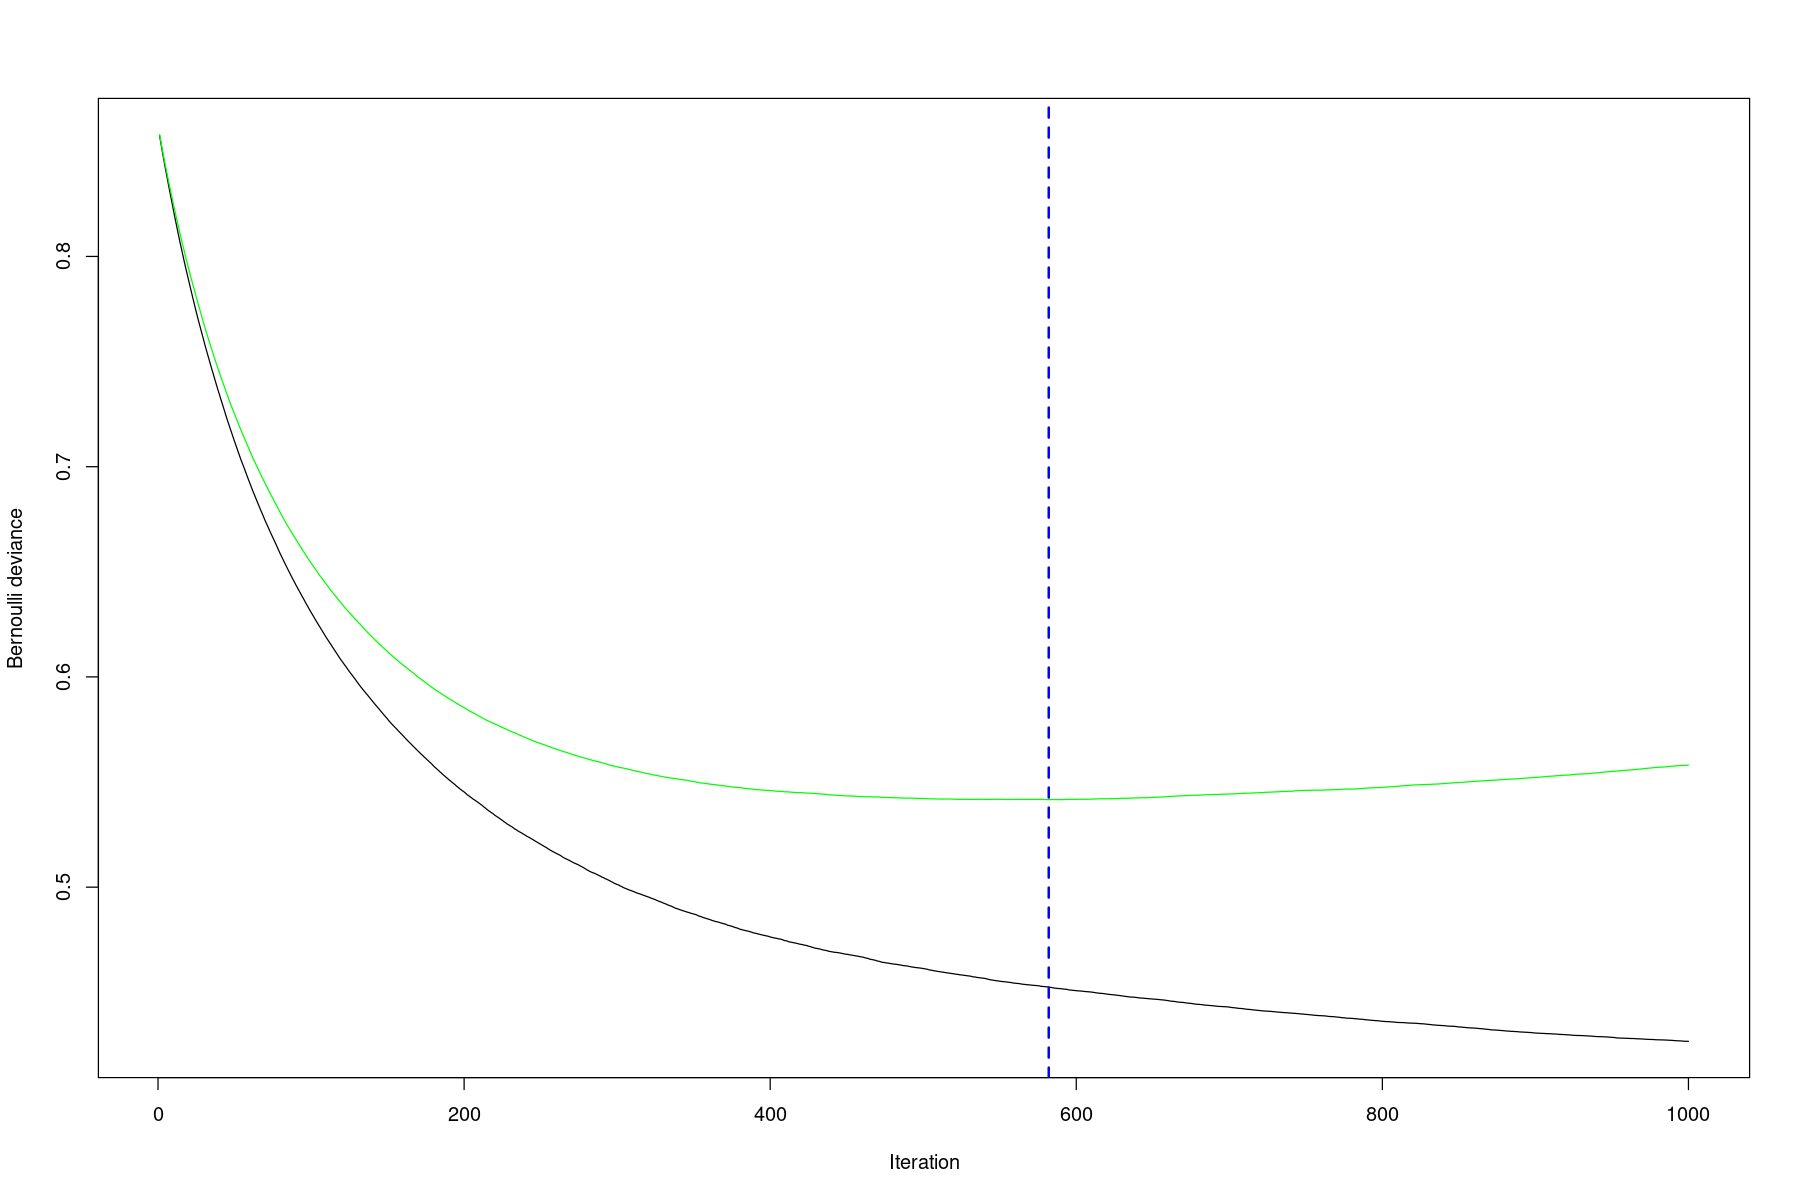

In [25]:
best_fit <- gbm.perf(retention_gbm5, method = "cv")
best_fit

In [26]:
data_to_eval = retention_train_clean
pred_retention <- predict(retention_gbm5, newdata = data_to_eval, type='response')

confusionMatrix(data = as.factor(ifelse(pred_retention>0.5, 1, 0)),
                reference = as.factor(data_to_eval$Revenue),
                positive='1',
                mode='prec_recall'
               )

Using 582 trees...




Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 8084  566
         1  254  961
                                          
               Accuracy : 0.9169          
                 95% CI : (0.9113, 0.9223)
    No Information Rate : 0.8452          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6534          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
              Precision : 0.79095         
                 Recall : 0.62934         
                     F1 : 0.70095         
             Prevalence : 0.15479         
         Detection Rate : 0.09742         
   Detection Prevalence : 0.12316         
      Balanced Accuracy : 0.79944         
                                          
       'Positive' Class : 1               
                                          

# Stochastic GBMs
Una de las grandes contribuciones de Breiman (el creador de bagging y RF) fue la idea de introducir muestras aleatorias en en el proceso de entrenamiento del modelo reduciendo la correlacion entre los modelos lo que ayuda a mejorar el performance. Estas ideas fueron introducidas tambien el bagging para reducir el overfitting y ayudar encontrar el minimo global del error. Este procedimeinto es conocido con *stochastic gradient boosting*.

Algunas de las variaciones de esta mejora son:
1. Muestreo de las observaciones (sin reemplazo) antes de crear cada arbol (gbm, xgboost, h20)
2. Muestreo de las columnas antes de crear cada arbol (xgboost, h20)
3. Muestreo de las columnas antes de cada split de los arboles (xgboost, h20)

Generalmente opcion (1) con valores del 50% o menos del conjunto de train pueden tener un efecto positivo en el performance del modelo (0.5-0.8). Por otro lado la opción (2) puede llegar a tener un gran impacto en el performance del modelo dependiendo del dataset que estemos usando, si existe una fuerte milticolinealidad (usar valores bajos) o features ruidosas o poco informaticas (usar valores altos). Finalmente al igual de RF se puede usar un hiper-parametro como mtry.

En general estos hiperparametros no tiene relacion con los otros hiperparametros vistos anteriormente.

XGBoost

Extreme gradient boosting (XGBoost) is an optimized distributed gradient boosting library that is designed to be efficient, flexible, and portable across multiple languages (Chen and Guestrin 2016). Although XGBoost provides the same boosting and tree-based hyperparameter options illustrated in the previous sections, it also provides a few advantages over traditional boosting such as:

* Regularization: XGBoost offers additional regularization hyperparameters, which we will discuss shortly, that provides added protection against overfitting.
* Early stopping: Similar to h2o, XGBoost implements early stopping so that we can stop model assessment when additional trees offer no improvement.
* Parallel Processing: Since gradient boosting is sequential in nature it is extremely difficult to parallelize. XGBoost has implemented procedures to support GPU and Spark compatibility which allows you to fit gradient boosting using powerful distributed processing engines.
* Loss functions: XGBoost allows users to define and optimize gradient boosting models using custom objective and evaluation criteria.
* Continue with existing model: A user can train an XGBoost model, save the results, and later on return to that model and continue building onto the results. Whether you shut down for the day, wanted to review intermediate results, or came up with additional hyperparameter settings to evaluate, this allows you to continue training your model without starting from scratch.
* Different base learners: Most GBM implementations are built with decision trees but XGBoost also provides boosted generalized linear models.
* Multiple languages: XGBoost offers implementations in R, Python, Julia, Scala, Java, and C++.

In addition to being offered across multiple languages, XGboost can be implemented multiple ways within R. The main R implementation is the xgboost package; however, as illustrated throughout many chapters one can also use caret as a meta engine to implement XGBoost. The h2o package also offers an implementation of XGBoost. In this chapter we’ll demonstrate the xgboost package.

## XGBoost hyperparameters
### Regularizacion
* gamma: is a pseudo-regularization hyperparameter known as a Lagrangian multiplier and controls the complexity of a given tree. gamma specifies a minimum loss reduction required to make a further partition on a leaf node of the tree. When gamma is specified, xgboost will grow the tree to the max depth and then prune the tree. ranges from 0−∞ (0 means no constraint while large numbers mean a higher regularization). What quantifies as a large gamma value is dependent on the loss function but generally lower values between 1–20 will do if gamma is influential.
* alpha: L1 
* lambda: L2
### Dropout
Dropout is an alternative approach to reduce overfitting and can loosely be described as regularization. The dropout approach developed by Srivastava et al. (2014a) has been widely employed in deep learnings to prevent deep neural networks from overfitting (see Section 13.7.3). Dropout can also be used to address overfitting in GBMs. When constructing a GBM, the first few trees added at the beginning of the ensemble typically dominate the model performance while trees added later typically improve the prediction for only a small subset of the feature space. This often increases the risk of overfitting and the idea of dropout is to build an ensemble by randomly dropping trees in the boosting sequence. This is commonly referred to as DART (Rashmi and Gilad-Bachrach 2015) since it was initially explored in the context of Mutliple Additive Regression Trees (MART); DART refers to Dropout Additive Regression Trees. The percentage of dropouts is another regularization parameter.

Typically, when gamma, alpha, or lambda cannot help to control overfitting, exploring DART hyperparameters would be the next best option.33

### Tuning strategy

The general tuning strategy for exploring xgboost hyperparameters builds onto the basic and stochastic GBM tuning strategies:

    Crank up the number of trees and tune learning rate with early stopping
    Tune tree-specific hyperparameters
    Explore stochastic GBM attributes
    If substantial overfitting occurs (e.g., large differences between train and CV error) explore regularization hyperparameters
    If you find hyperparameter values that are substantially different from default settings, be sure to retune the learning rate
    Obtain final “optimal” model

Running an XGBoost model with xgboost requires some additional data preparation. xgboost requires a matrix input for the features and the response to be a vector. Consequently, to provide a matrix input of the features we need to encode our categorical variables numerically (i.e. one-hot encoding, label encoding). The following numerically label encodes all categorical features and converts the training data frame to a matrix.


|Model|Method|Type|Libraries|Tuning Parameters|
|---|---|---|---|---|
|eXtreme Gradient Boosting|xgbDART|Classification, Regression|xgboost, plyr|nrounds, max_depth, eta, gamma, subsample, colsample_bytree, rate_drop, skip_drop, min_child_weight|
|eXtreme Gradient Boosting|xgbLinear|Classification, Regression|xgboost|nrounds, lambda, alpha, eta|
|eXtreme Gradient Boosting|xgbTree|Classification, Regression|xgboost, plyr|nrounds, max_depth, eta, gamma, colsample_bytree, min_child_weight, subsample|
<img src=https://scikit-learn.org/stable/_images/sphx_glr_plot_gradient_boosting_regularization_001.png>

## Prepare data

In [12]:
prep_retention2 <- recipe(Revenue ~ ., data = retention_train) %>%
    step_medianimpute(all_of(numerical)) %>% 
    step_string2factor(all_of(categorical)) %>% 
    step_knnimpute(all_of(categorical)) %>% 
    step_dummy(all_of(categorical)) %>% 
    step_mutate(Revenue = as.integer(Revenue)) %>% 
    prep()
    
retention_train_clean2  <-  bake(prep_retention2, retention_train)
retention_test_clean2  <-  bake(prep_retention2, retention_test)

X <- as.matrix(retention_train_clean2[setdiff(names(retention_train_clean2), "Revenue")])
Y <- retention_train_clean2$Revenue

## Base model

LA forma más simple de usar XGBoost es usando la funcion `xgboost` y dale algunos paramatros para el entrenemiento y ver como nos da el resultado.


* objetive:
  * reg:logistic logistic regression.
  * binary:logistic logistic regression for binary classification. Output probability.
  * binary:hinge: hinge loss for binary classification. This makes predictions of 0 or 1, rather than producing probabilities.
* eval_metric: [documentation](https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters)
* booster = "gbtree",  # puede ser gbtree o gblinear. Por defecto gbtree
* eta: Learning rate / shrinkage. Por defecto 0.3
* max_depth: maxima profundidad de cada arbol. Por defecto 6,  
* min_child_weight: numero minimo de observaciones () en una hoja. Por defecto 1
* subsample: Subsample sin reemplazo con el que se entrena cada nuevo arbol. Por defecto 1
* colsample_bytree: Porcentaje de columnas consideradas para el entrenamiento de cada modelo. Por defecto 1
* scale_pos_weight:

### Model 1

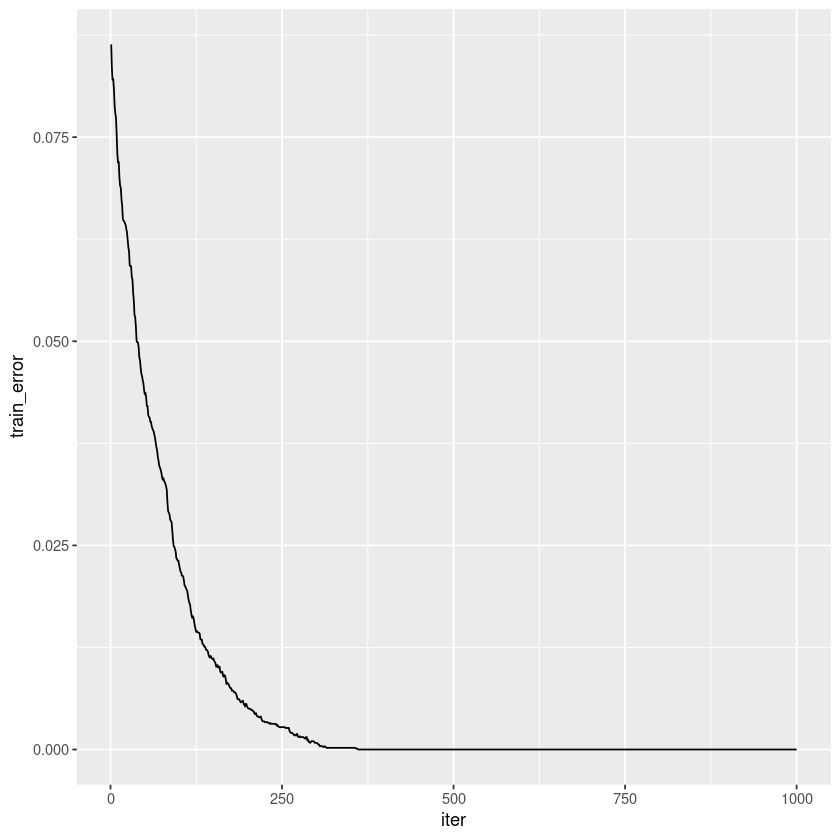

In [49]:
set.seed(42)

params <- list(
  booster = "gbtree",
  objective = "binary:logistic",
  eta = 0.3,
  max_depth = 6,
  min_child_weight = 1,
  subsample = 1,
  colsample_bytree = 1
)

retention_xgb_basic1 <- xgboost(
  params = params,
  data = X,
  label = Y,
  nrounds = 1000,
  verbose = 0
)

retention_xgb_basic1$evaluation_log %>% 
    ggplot(aes(iter, train_error)) + geom_line()

In [36]:
retention_xgb_basic1train$params

$eta
[1] 0.01

$max_depth
[1] 3

$min_child_weight
[1] 3

$subsample
[1] 0.5

$colsample_bytree
[1] 0.5

$objective
[1] "binary:logistic"

$validate_parameters
[1] TRUE

### Model 2

[1]	train-error:0.156412 
[2]	train-error:0.154283 
[3]	train-error:0.145261 
[4]	train-error:0.118804 
[5]	train-error:0.133604 
[6]	train-error:0.114344 
[7]	train-error:0.102179 
[8]	train-error:0.114344 
[9]	train-error:0.104815 
[10]	train-error:0.100558 
[11]	train-error:0.104207 
[12]	train-error:0.101470 
[13]	train-error:0.097516 
[14]	train-error:0.093969 
[15]	train-error:0.098733 
[16]	train-error:0.103193 
[17]	train-error:0.100051 
[18]	train-error:0.099037 
[19]	train-error:0.100862 
[20]	train-error:0.098834 
[21]	train-error:0.098023 
[22]	train-error:0.096300 
[23]	train-error:0.095388 
[24]	train-error:0.094780 
[25]	train-error:0.094070 
[26]	train-error:0.095793 
[27]	train-error:0.094070 
[28]	train-error:0.092347 
[29]	train-error:0.093158 
[30]	train-error:0.092955 
[31]	train-error:0.092043 
[32]	train-error:0.092854 
[33]	train-error:0.092245 
[34]	train-error:0.091840 
[35]	train-error:0.092854 
[36]	train-error:0.092955 
[37]	train-error:0.093664 
[38]	train

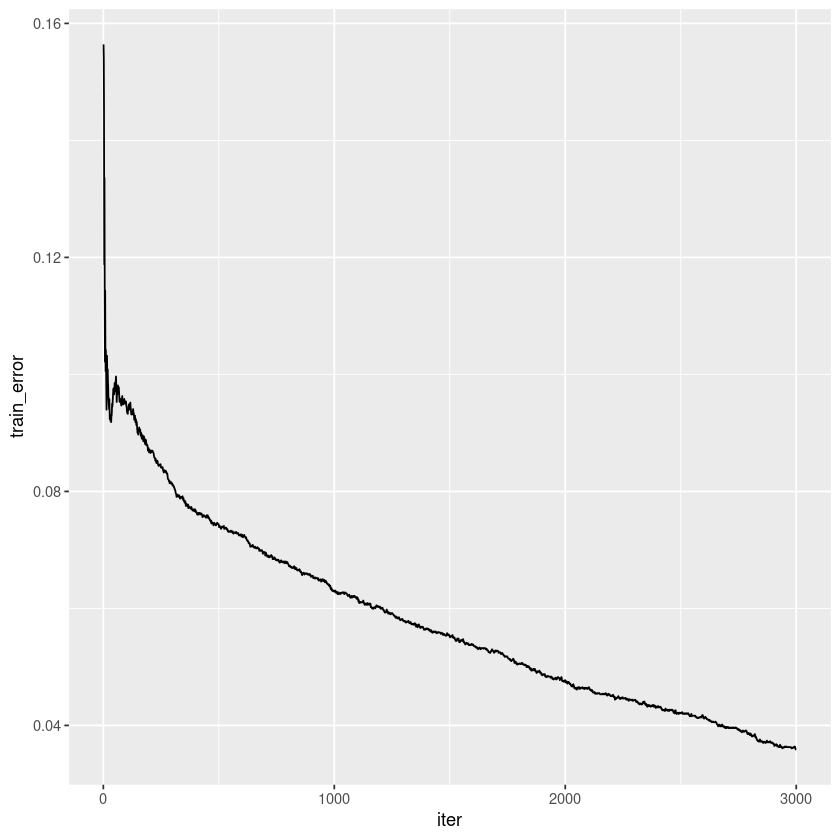

In [45]:
set.seed(42)

params <- list(
  booster = "gbtree",
  objective = "binary:logistic",
  eta = 0.3,
  max_depth = 6,
  min_child_weight = 1,
  subsample = 1,
  colsample_bytree = 1
)

retention_xgb_basic2 <- xgboost(
  params = params,
  data = X,
  label = Y,
  nrounds = 3000,
  objective = "binary:logistic",
  verbose = 0
)

retention_xgb_basic2$evaluation_log %>% 
    ggplot(aes(iter, train_error)) + geom_line()

### CV

XGBoost tiene otras funciones que nos permiten tener mayor control del proceso de entrenamiento y evaluacion de este, uno de estos metodos es `xgb.cv` y `xgb.train`. Adicionalmente podemos incluir algunas metricas para ver la ecolucion de esa metrica en cada iteración.

In [18]:
set.seed(42)

params <- list(
  booster = "gbtree",
  objective = "binary:logistic",
  eta = 0.3,
  max_depth = 6,
  min_child_weight = 1,
  subsample = 1,
  colsample_bytree = 1,
  eval_metric = 'auc',
  eval_metric = 'error',
  eval_metric = 'logloss'
)

retention_xgb_cv <- xgb.cv(
  data = X,
  label = Y,
  nrounds = 1000,
  nfold = 5,
  params = params,
  stratified = TRUE,
  early_stopping_rounds = 50,   stratified = TRUE,
  verbose = 0
)  

In [18]:
retention_xgb_cv$evaluation_log %>% 
    tail()

iter,train_auc_mean,train_auc_std,train_error_mean,train_error_std,train_logloss_mean,train_logloss_std,test_auc_mean,test_auc_std,test_error_mean,test_error_std,test_logloss_mean,test_logloss_std
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
59,0.9897424,0.0006734133,0.0339584,0.001460221,0.1128418,0.002495604,0.9235958,0.007074474,0.1039026,0.002883425,0.2425192,0.008440340
60,0.9898998,0.0006628880,0.0333756,0.001466082,0.1121084,0.002461559,0.9234134,0.007082187,0.1037000,0.002946933,0.2429922,0.008304011
61,0.9900880,0.0006368507,0.0330206,0.001641557,0.1113248,0.002428732,0.9232266,0.006956475,0.1040040,0.002240835,0.2433976,0.008243945
62,0.9903300,0.0007900139,0.0324632,0.001973002,0.1104606,0.002793594,0.9232290,0.007114788,0.1034972,0.002104254,0.2435882,0.008565961
63,0.9905282,0.0007508292,0.0319056,0.002082417,0.1098560,0.002683727,0.9230856,0.006961189,0.1038012,0.002240799,0.2438522,0.008465099
64,0.9907646,0.0007333473,0.0315254,0.002145911,0.1089892,0.002627197,0.9230620,0.006896673,0.1039026,0.002094691,0.2439974,0.008610672


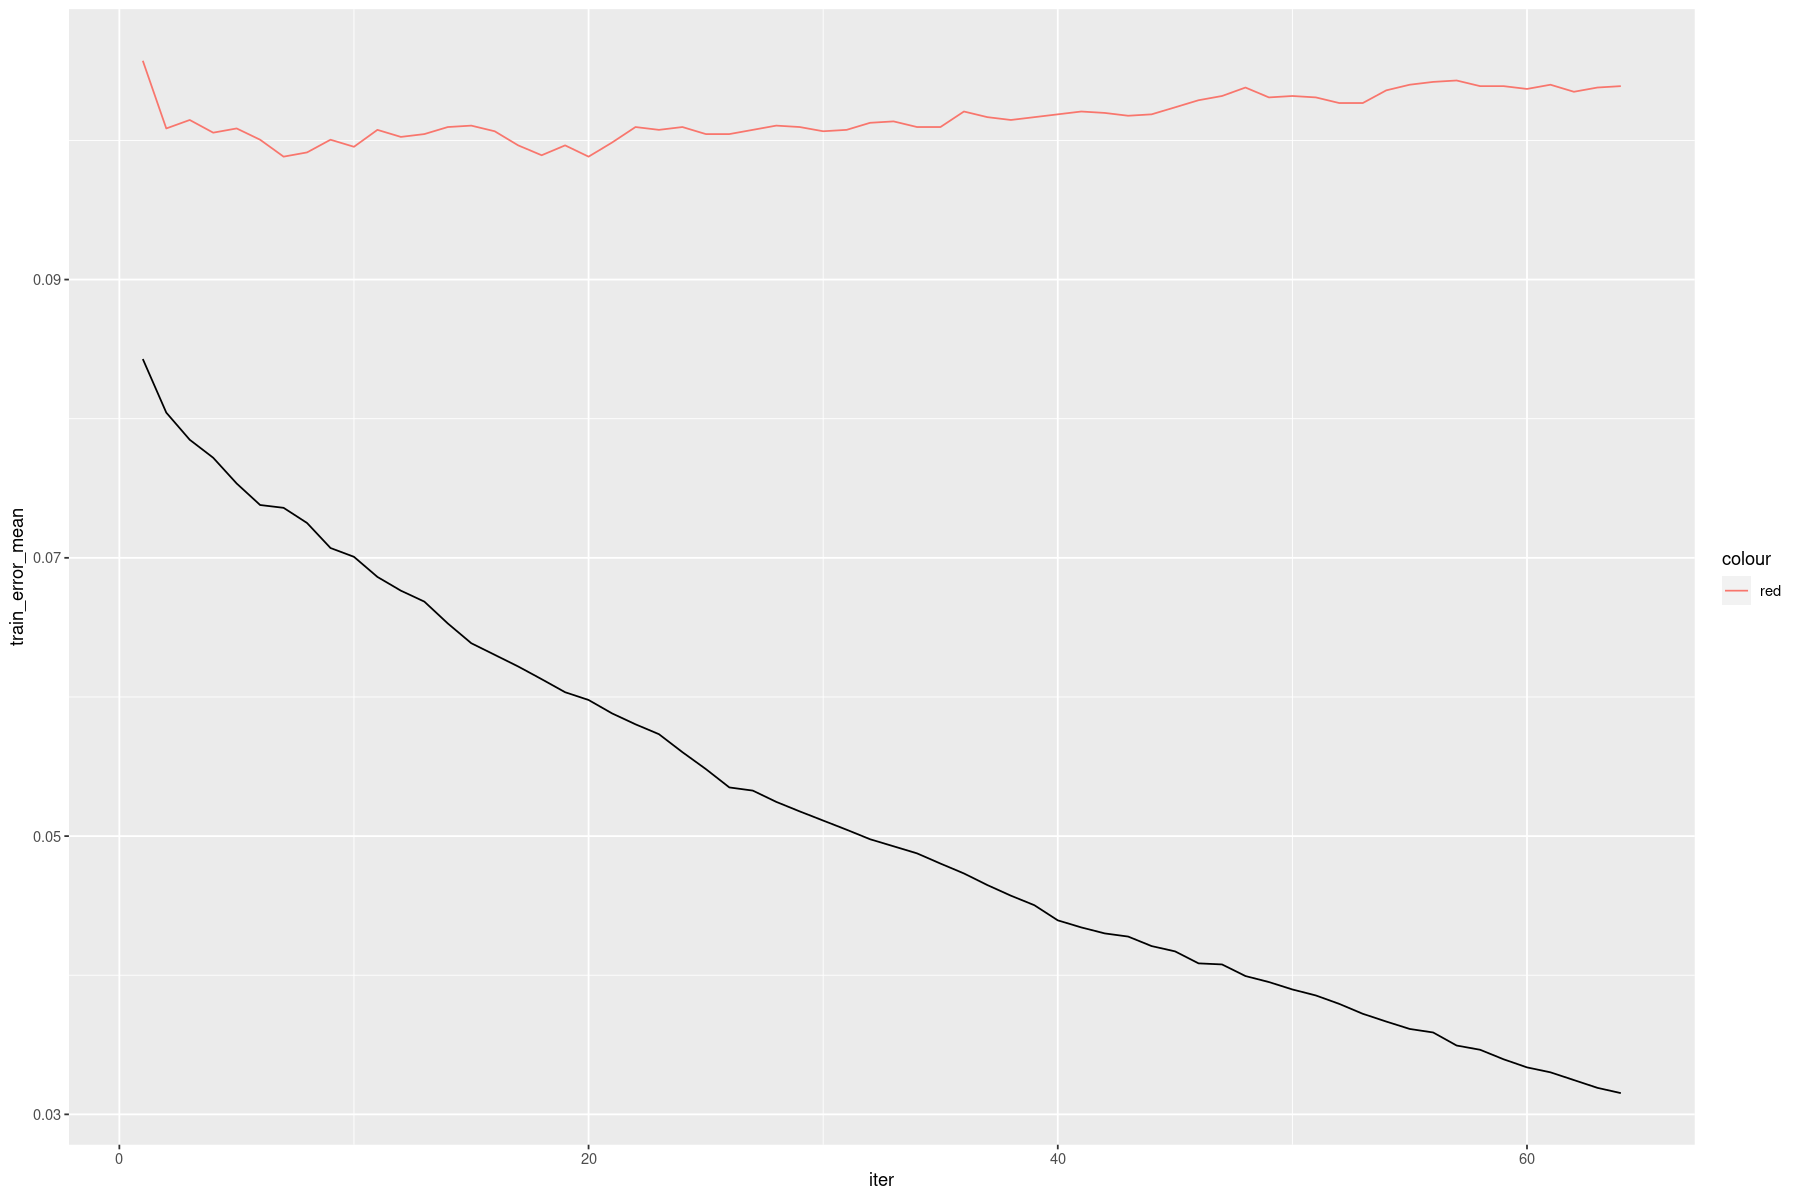

In [19]:
retention_xgb_cv$evaluation_log %>% 
    ggplot(aes(iter, train_error_mean)) +
        geom_line() + 
        geom_line(aes(iter, test_error_mean, color='red'))

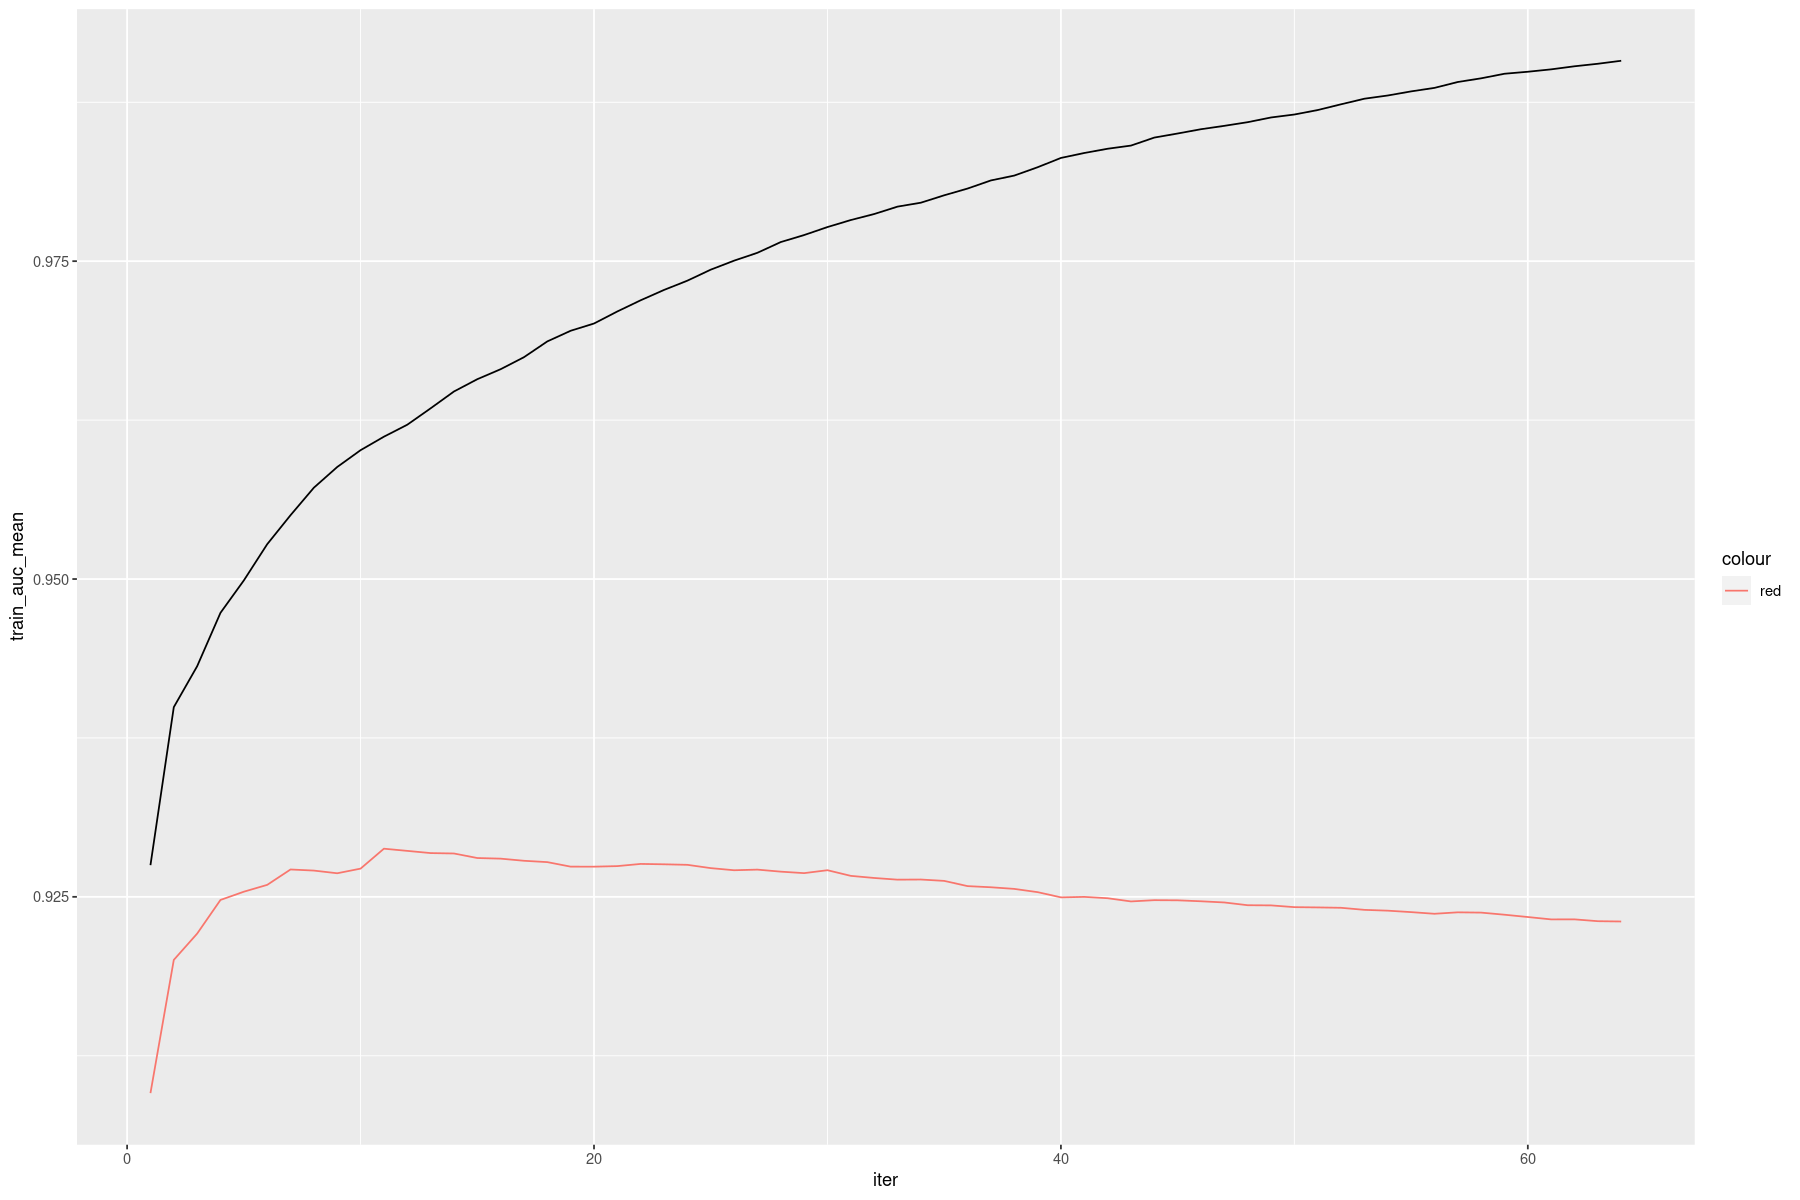

In [20]:
retention_xgb_cv$evaluation_log %>% 
    ggplot(aes(iter, train_auc_mean)) +
        geom_line() + 
        geom_line(aes(iter, test_auc_mean, color='red'))

## Fine tuning xgboost
[ref fine tuning](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

In [ ]:
# hyperparameter grid
hyper_grid <- expand.grid(
  eta = 0.01,
  max_depth = 3, 
  min_child_weight = 3,
  subsample = 0.5, 
  colsample_bytree = 0.5,
  gamma = c(0, 1, 10, 100, 1000),
  lambda = c(0, 1e-2, 0.1, 1, 100, 1000, 10000),
  alpha = c(0, 1e-2, 0.1, 1, 100, 1000, 10000),
  rmse = NA,          # a place to dump RMSE results
  trees = NA          # a place to dump required number of trees
)

# grid search
for(i in seq_len(nrow(hyper_grid))) {
  set.seed(123)
  m <- xgb.cv(
    data = X,
    label = Y,
    nrounds = 4000,
    objective = "reg:squarederror",
    early_stopping_rounds = 50, 
    nfold = 10,
    verbose = 0,
    params = list( 
      eta = hyper_grid$eta[i], 
      max_depth = hyper_grid$max_depth[i],
      min_child_weight = hyper_grid$min_child_weight[i],
      subsample = hyper_grid$subsample[i],
      colsample_bytree = hyper_grid$colsample_bytree[i],
      gamma = hyper_grid$gamma[i], 
      lambda = hyper_grid$lambda[i], 
      alpha = hyper_grid$alpha[i]
    ) 
  )
  hyper_grid$rmse[i] <- min(m$evaluation_log$test_rmse_mean)
  hyper_grid$trees[i] <- m$best_iteration
}

# results
hyper_grid %>%
  filter(rmse > 0) %>%
  arrange(rmse) %>%
  glimpse()

In [ ]:
# optimal parameter list




In [ ]:
plot(xgb.fit.final$evaluation_log$train_rmse)

### Feature interpretation

Measuring GBM feature importance and effects follows the same construct as random forests. Similar to random forests, the gbm and h2o packages offer an impurity-based feature importance. xgboost actually provides three built-in measures for feature importance:

    Gain: This is equivalent to the impurity measure in random forests (reference Section 11.6) and is the most common model-centric metric to use.
    Coverage: The Coverage metric quantifies the relative number of observations influenced by this feature. For example, if you have 100 observations, 4 features and 3 trees, and suppose x1

is used to decide the leaf node for 10, 5, and 2 observations in tree1, tree2 and tree3 respectively; then the metric will count cover for this feature as 10+5+2=17
observations. This will be calculated for all the 4 features and expressed as a percentage.
Frequency: The percentage representing the relative number of times a particular feature occurs in the trees of the model. In the above example, if x1
was used for 2 splits, 1 split and 3 splits in each of tree1, tree2 and tree3 respectively; then the weightage for x1 will be 2+1+3=6. The frequency for x1 is calculated as its percentage weight over weights of all xp features.

If we examine the top 10 influential features in our final model using the impurity (gain) metric, we see very similar results as we saw with our random forest model (Section 11.6). The primary difference is we no longer see Neighborhood as a top influential feature, which is likely a result of how we label encoded the categorical features.

In [ ]:
importance_matrix <- xgb.importance(model=xgb.fit.final)

In [ ]:
head(importances)

In [ ]:
xgb.plot.importance(importance_matrix = importance_matrix)

In [ ]:
vip::vip(xgb.fit.final, type="gain", num_features = 25)

In [ ]:
vip::vip(xgb.fit.final, type="cover", num_features = 25)

In [ ]:
vip::vip(xgb.fit.final, type="frequency", num_features = 25)

In [ ]:
# Save model
xgb.save(bst, "xgboost.model")
# load binary model to R
bst2 <- xgb.load("xgboost.model")
pred2 <- predict(bst2, test$data)

In [ ]:
xgb.plot.tree(model = bst)